# Model Training

- **Purpose:** Environment setup and loading/validating feature-engineered dataset for fraud model training  
- **Author:** Devbrew LLC  
- **Last Updated:** October 30, 2025  
- **Status:** In progress  
- **License:** Apache 2.0 (Code) | Non-commercial (Data)

---

## Dataset License Notice

This notebook uses the **IEEE-CIS Fraud Detection dataset** from Kaggle.

**Dataset License:** Non-commercial research use only  
- You must download the dataset yourself from [Kaggle IEEE-CIS Competition](https://www.kaggle.com/c/ieee-fraud-detection)  
- You must accept the competition rules before downloading  
- Cannot be used for commercial purposes  
- Cannot redistribute the raw dataset

**Setup Instructions:** See [`../data_catalog/README.md`](../data_catalog/README.md) for download instructions.

**Code License:** This notebook's code is licensed under Apache 2.0 (open source).

---

## Notebook Configuration

### Environment Setup

We configure the Python environment with standardized settings, import required libraries, and set a fixed random seed for reproducibility. This ensures consistent results across runs and enables reliable experimentation.

These settings establish the foundation for all model training operations.

In [35]:
import warnings
from pathlib import Path
import json
import hashlib
from typing import Dict, Any, Optional, Tuple
import time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, 
    precision_recall_fscore_support, confusion_matrix, classification_report)



# Configuration
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
pd.set_option("display.float_format", '{:.2f}'.format)

# Plotting configuration
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Environment configured successfully")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"lightgbm: {lgb.__version__}")

Environment configured successfully
pandas: 2.3.3
numpy: 2.3.3
lightgbm: 4.6.0


### Path Configuration

We define the project directory structure and validate that required processed data from feature engineering exists. The validation ensures we have the necessary inputs before proceeding with training.

This configuration pattern ensures we can locate all required data artifacts from previous pipeline stages.

In [36]:
# Project paths
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data_catalog"
IEEE_CIS_DIR = DATA_DIR / "ieee-fraud"
PROCESSED_DIR = DATA_DIR / "processed"
NOTEBOOKS_DIR = PROJECT_ROOT / "notebooks"

# Ensure processed directory exists
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Expected artifacts
FEATURES_PATH = PROCESSED_DIR / "train_features.parquet"
FE_METADATA_PATH = PROCESSED_DIR / "feature_engineering_metadata.json"

def validate_required_artifacts():
    """Validate that required artifacts exist before training."""
    path_status = {
        'train_features.parquet': FEATURES_PATH.exists(),
        'feature_engineering_metadata.json': FE_METADATA_PATH.exists()
    }
    print("Artifact Availability Check:")
    for name, exists in path_status.items():
        status = "Found" if exists else "Missing"
        print(f" - {name}: {status}")

    all_exist = all(path_status.values())

    if not all_exist:
        print("\n[WARNING] Some artifacts are missing; ensure feature engineering completed successfully")
    else:
        print("\nAll required artifacts are available")

artifact_status = validate_required_artifacts()

Artifact Availability Check:
 - train_features.parquet: Found
 - feature_engineering_metadata.json: Found

All required artifacts are available


## Load Features & Data Manifest

We load the feature-engineered dataset and validate integrity against recorded metadata. We also create a simple data manifest to document:
- shape
- feature count
- missing values
- target distribution (`isFraud`)
- memory footprint
- file hash (for reproducibility)

### Validation Checklist
- Verify shape matches metadata (590,540 × 432)
- Confirm zero missing values
- Check target distribution (~3.5% fraud rate)
- Validate `TransactionDT` exists for time-based split
- Validate identifiers (`TransactionID`) and target (`isFraud`) are present

In [37]:
def file_sha256(path: Path, chunk_size: int = 2**20) -> Optional[str]:
    """Compute SHA-256 hash of a file; returns None if file missing"""
    if not path.exists():
        return None
    h = hashlib.sha256()
    with path.open("rb") as f:
        while True:
            chunk = f.read(chunk_size)
            if not chunk:
                break
            h.update(chunk)
    return h.hexdigest()

def build_data_manifest(df: pd.DataFrame, file_path: Path, fe_meta: Optional[Dict[str, Any]]) -> Dict[str, Any]:
    """Create a manifest capturing data properties for reproducibility."""
    manifest: Dict[str, Any] = {
        "generated_at": pd.Timestamp.now().isoformat(),
        "source_file": str(file_path),
        "source_hash_sha256": file_sha256(file_path),
        "rows": int(df.shape[0]),
        "columns": int(df.shape[1]),
        "memory_gb": float(df.memory_usage().sum() / 1e9),
        "dtypes_summary": df.dtypes.astype(str).value_counts().to_dict(),
        "null_values_total": int(df.isna().sum().sum()),
        "columns_with_nulls": df.columns[df.isna().any()].tolist(),
        "target": "isFraud",
        "target_distribution": df["isFraud"].value_counts(dropna=False).to_dict() if "isFraud" in df.columns else {},
        "target_rate": float(df["isFraud"].mean()) if "isFraud" in df.columns else None,
        "has_transactiondt": bool("TransactionDT" in df.columns),
        "has_transactionid": bool("TransactionID" in df.columns),
        "random_state": RANDOM_STATE,
    }

    if fe_meta:
        manifest["feature_engineering_metadata"] = {
            "total_features_expected": fe_meta.get("total_features"),
            "dataset_shape_expected": fe_meta.get("dataset_shape"),
            "engineering_date": fe_meta.get("engineering_date"),
        }

    return manifest

# Load feature engineering metadata if available
fe_meta = None
if FE_METADATA_PATH.exists():
    with open(FE_METADATA_PATH, "r") as f:
        fe_meta = json.load(f)

print("Loading Feature-Engineered Data...")
if not FEATURES_PATH.exists():
    raise FileNotFoundError(f"Missing features file: {FEATURES_PATH}")

df = pd.read_parquet(FEATURES_PATH)
print(f"Loaded features: {df.shape[0]:,} rows x {df.shape[1]:,} columns")
print(f"Memory usage: {df.memory_usage().sum() / 1e9:.2f} GB")

# Basic target info
if "isFraud" in df.columns:
    print("\nTarget Distribution:")
    print(pd.Series(df["isFraud"]).value_counts())
    print(f"Fraud rate: {df['isFraud'].mean() * 100:.2f}%")
else:
    print("\n[WARNING] 'isFraud' target column not found in features dataset")

# Data check vs metadata
if fe_meta and "dataset_shape" in fe_meta:
    expected_rows, expected_cols = fe_meta["dataset_shape"]
    ok_shape = (df.shape[0] == expected_rows) and (df.shape[1] == expected_cols)
    print(f"\nShape validation vs metadata: {'PASS' if ok_shape else 'FAIL'}")
    print(f" - (Expected {expected_rows:,} x {expected_cols:,} columns, got {df.shape[0]:,} x {df.shape[1]:,} columns)")
else:
    print("\n[WARNING] Feature engineering metadata not availables for shape validation")

# Nulls
total_nulls = int(df.isnull().sum().sum())
print(f"\nTotal missing values: {total_nulls:,}")

# Key column presence
print(f"Has TransactionDT: {'Yes' if 'TransactionDT' in df.columns else 'No'}")
print(f"Has TransactionID: {'Yes' if 'TransactionID' in df.columns else 'No'}")
    

# Dtypes quick summary
dtype_counts = df.dtypes.astype(str).value_counts()
print("\nDtype Summary:")
for dtype, count in dtype_counts.items():
    print(f" - {dtype}: {count}")

# Build and save manifest
manifest = build_data_manifest(df, FEATURES_PATH, fe_meta)

# Save manifest to data catalog
MANIFEST_PATH = PROCESSED_DIR / "training_data_manifest.json"
MANIFEST_PATH.parent.mkdir(parents=True, exist_ok=True)
with open(MANIFEST_PATH, "w") as f:
    json.dump(manifest, f, indent=4)
print(f"\nTraining data manifest saved to: {MANIFEST_PATH}")

Loading Feature-Engineered Data...
Loaded features: 590,540 rows x 432 columns
Memory usage: 2.04 GB

Target Distribution:
isFraud
0    569877
1     20663
Name: count, dtype: int64
Fraud rate: 3.50%

Shape validation vs metadata: PASS
 - (Expected 590,540 x 432 columns, got 590,540 x 432 columns)

Total missing values: 0
Has TransactionDT: Yes
Has TransactionID: Yes

Dtype Summary:
 - float64: 394
 - object: 29
 - int64: 9

Training data manifest saved to: /Users/joekariuki/Documents/Devbrew/research/devbrew-payments-fraud-sanctions/data_catalog/processed/training_data_manifest.json


### Notes

- Shapes validated against [feature_engineering_metadata.json](../data_catalog/processed/feature_engineering_metadata.json): expected `(590,540 × 432)`.  
- `TransactionDT` presence is required for time-based splits in train/test/validation split.  
- We persist a `training_data_manifest.json` documenting data properties and file hash for reproducibility.  

## Train/Validation/Test Split (Time-Based)

We perform a chronological split to respect temporal causality in fraud detection. Random splitting would allow the model to see future data during training, inflating performance metrics and violating real-world deployment conditions.

We split the data into 60% train (earliest transactions), 20% validation (middle period), and 20% test (most recent transactions). This simulates production deployment where models score transactions as they arrive over time, and ensures fraudsters' evolving tactics are properly reflected in our evaluation.

This approach follows industry standards for fraud detection in payment systems and meets regulatory requirements for model validation.

In [38]:
SPLITS_DIR = PROCESSED_DIR / "splits"
SPLITS_DIR.mkdir(parents=True, exist_ok=True)

def temporal_split(
    df_in: pd.DataFrame, 
    ts_col: str = "TransactionDT",
    id_col: str = "TransactionID",
    target_col: str = "isFraud",
    train_frac: float = 0.60,
    val_frac: float = 0.20,
    ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, Dict[str, Any]]:
    """
    Perform chronological time-based split with temporal leak prevention for fraud detection.
    
    Ensures training data is strictly earlier than validation/test data. This is critical for
    fraud models where future patterns must not leak into training. Common issue in
    production: models trained with random splits show inflated metrics but fail in
    real-time scoring due to temporal leakage.
    
    Parameters:
        df_in: Input dataframe with transactions
        ts_col: Timestamp column for temporal ordering (default: "TransactionDT")
        id_col: Transaction ID column (default: "TransactionID")
        target_col: Binary fraud label (default: "isFraud")
        train_frac: Training fraction (default: 0.60)
        val_frac: Validation fraction (default: 0.20, test gets remainder)
    
    Returns:
        train_df, val_df, test_df: Chronologically split dataframes
        splits_df: Metadata with split labels for visualization
        stats: Comprehensive dict with:
            - Split metrics and temporal boundaries
            - Class distribution and drift analysis (fraud rate shifts)
            - Validation checks (no temporal leakage, no ID overlap)
            - Dataset provenance for reproducibility
    
    Validations performed:
        - Strict temporal ordering: train_max < val_min < test_max
        - No transaction ID overlap between splits
        - Fraud rate drift monitoring (flags if >0.5pp shift between splits)
    """
    # Sort chronologically to ensure temporal ordering for time-series split
    df_sorted = df_in.sort_values(ts_col).reset_index(drop=True)

    # Compute split indices based on configured fractions
    n = len(df_sorted)
    train_end = int(n * train_frac)
    val_end = int(n * (train_frac + val_frac))

    train_df = df_sorted.iloc[:train_end]
    val_df = df_sorted.iloc[train_end:val_end]
    test_df = df_sorted.iloc[val_end:]

    # Create split labels dataframe for visualization and distribution analysis
    split_labels = (['train'] * len(train_df)) + \
                  (['val'] * len(val_df)) + \
                  (['test'] * len(test_df))
    splits_df = df_sorted[[id_col, ts_col, target_col]].copy()
    splits_df['split'] = split_labels

    # Validate temporal boundaries: critical check for preventing data leakage
    train_max_ts = float(train_df[ts_col].max())
    val_min_ts = float(val_df[ts_col].min())
    val_max_ts = float(val_df[ts_col].max())
    test_min_ts = float(test_df[ts_col].min())

    no_temporal_leak_train_val = train_max_ts < val_min_ts
    no_temporal_leak_val_test = val_max_ts < test_min_ts 

    # Verify no transaction ID overlap across splits
    train_ids = set(train_df[id_col].tolist())
    val_ids = set(val_df[id_col].tolist())
    test_ids = set(test_df[id_col].tolist())
    
    no_id_overlap = (len(train_ids & val_ids) == 0) and \
                    (len(train_ids & test_ids) == 0) and \
                    (len(val_ids & test_ids) == 0)

    # Compute fraud rate drift across splits to monitor distribution stability
    def rate(d: pd.DataFrame) -> float:
        """Calculate fraud rate (mean of binary target)"""
        return float(d[target_col].mean() if len(d) else float('nan'))
    
    train_rate = rate(train_df)
    val_rate = rate(val_df)
    test_rate = rate(test_df)

    drift_train_val_pp = abs(train_rate - val_rate) * 100
    drift_train_test_pp = abs(train_rate - test_rate) * 100
    drift_val_test_pp = abs(val_rate - test_rate) * 100
    
    # Assemble comprehensive statistics and validation results
    try:
        source_hash = manifest.get("source_hash_sha256") if isinstance(manifest, dict) else None
    except NameError:
        source_hash = None
    
    stats: Dict[str, Any] = {
        "method": "time_chronological_split",
        "fractions": {
            "train": train_frac,
            "val": val_frac,
            "test": 1.0 - train_frac - val_frac
        },
        "counts": {
            "train": int(len(train_df)),
            "val": int(len(val_df)),
            "test": int(len(test_df)),
            "total": int((n))
        },
        "timestamp_cutoffs": {
            "train_max": train_max_ts,
            "val_min": val_min_ts,
            "val_max": val_max_ts,
            "test_min": test_min_ts
        },
        "class_rates": {
            "train_rate": train_rate,
            "val_rate": val_rate,
            "test_rate": test_rate
        },
        "drift_pp": {
            "train_vs_val": drift_train_val_pp,
            "train_vs_test": drift_train_test_pp,
            "val_vs_test": drift_val_test_pp
        },
        "checks": {
            "no_temporal_leak_train_val": bool(no_temporal_leak_train_val),
            "no_temporal_leak_val_test": bool(no_temporal_leak_val_test),
            "no_overlap_by_id": bool(no_id_overlap),
            "fraud_rate_similarity_within_0_5_pp": bool((drift_train_val_pp <= 0.5) and (drift_val_test_pp <= 0.5))
        },
        "dataset_provenance": {
            "features_path": str(FEATURES_PATH),
            "source_hash_sha256": source_hash or file_sha256(FEATURES_PATH),
            "random_state": RANDOM_STATE
        }
    }

    return train_df, val_df, test_df, splits_df, stats

### Execute Split and Persist Artifacts

We execute the temporal split, save the split indices for reproducibility, and validate data quality checks.

**Key Industry Context:**
- Random splits can inflate model performance by 10-20 percentage points
- Regulatory frameworks (SR 11-7, Model Risk Management) require temporal validation
- Production fraud models must handle concept drift as fraudsters adapt tactics

In [39]:
# Execute the temporal split
train_df, val_df, test_df, splits_index_df, split_stats = temporal_split(df)

# Persists split indices and metadata
splits_index_path = SPLITS_DIR / "temporal_splits.csv"
splits_index_df[['TransactionID', 'split']].to_csv(splits_index_path, index=False)

for name, part in [('train', train_df), ('val', val_df), ('test', test_df)]:
    out_path = SPLITS_DIR / f"{name}_ids.csv"
    out_path.write_text("TransactionID\n" + "\n" .join(part["TransactionID"].astype(str).tolist()))

with open(SPLITS_DIR / "splits_metadata.json", "w") as f:
    json.dump(split_stats, f, indent=4)

# Summary
print("Time-based split complete. Summary:")
print(f" - Counts: train={split_stats['counts']['train']:,}, val={split_stats['counts']['val']:,}, test={split_stats['counts']['test']:,}")
print(" - Timestamp cutoffs:")
print(f"   - train_max < val_min < test_min => {split_stats['checks']['no_temporal_leak_train_val']} & {split_stats['checks']['no_temporal_leak_val_test']}")
print(f" - Fraud rates (%):")
print(f"   - train={split_stats['class_rates']['train_rate']*100:.2f}, val={split_stats['class_rates']['val_rate']*100:.2f}, test={split_stats['class_rates']['test_rate']*100:.2f}")
print(f" - Drift (pp):")
print(f"   - train-vs-val={split_stats['drift_pp']['train_vs_val']:.3f}, train-vs-test={split_stats['drift_pp']['train_vs_test']:.3f}, val-vs-test={split_stats['drift_pp']['val_vs_test']:.3f}")
print(f" - No overlap by ID: {split_stats['checks']['no_overlap_by_id']}")
print(f" - Fraud rate similarity within ±0.5pp (train/val and val/test): {split_stats['checks']['fraud_rate_similarity_within_0_5_pp']}")
print(f"Artifacts saved to: {SPLITS_DIR}")

Time-based split complete. Summary:
 - Counts: train=354,324, val=118,108, test=118,108
 - Timestamp cutoffs:
   - train_max < val_min < test_min => True & True
 - Fraud rates (%):
   - train=3.38, val=3.90, test=3.44
 - Drift (pp):
   - train-vs-val=0.521, train-vs-test=0.058, val-vs-test=0.463
 - No overlap by ID: True
 - Fraud rate similarity within ±0.5pp (train/val and val/test): False
Artifacts saved to: /Users/joekariuki/Documents/Devbrew/research/devbrew-payments-fraud-sanctions/data_catalog/processed/splits


### Data Quality Validation

We assert critical data quality checks that would fail a production model review:
- **Temporal leakage prevention**: Ensures no future data contaminates training
- **ID uniqueness**: Prevents same transaction appearing in multiple splits  
- **Distribution monitoring**: Flags significant fraud rate shifts requiring investigation

These checks align with model governance requirements at financial institutions.

In [40]:
assert split_stats["checks"]["no_temporal_leak_train_val"], "Temporal leak between train and val!"
assert split_stats["checks"]["no_temporal_leak_val_test"], "Temporal leak between val and test!"
assert split_stats["checks"]["no_overlap_by_id"], "Transaction ID overlap across splits!"
if not split_stats["checks"]["fraud_rate_similarity_within_0_5_pp"]:
    print(f"[WARNING] Fraud rate drift between exceeds ±0.5pp. Investigate distribution shift or adjust boundaries")

[WARNING] Fraud rate drift between exceeds ±0.5pp. Investigate distribution shift or adjust boundaries


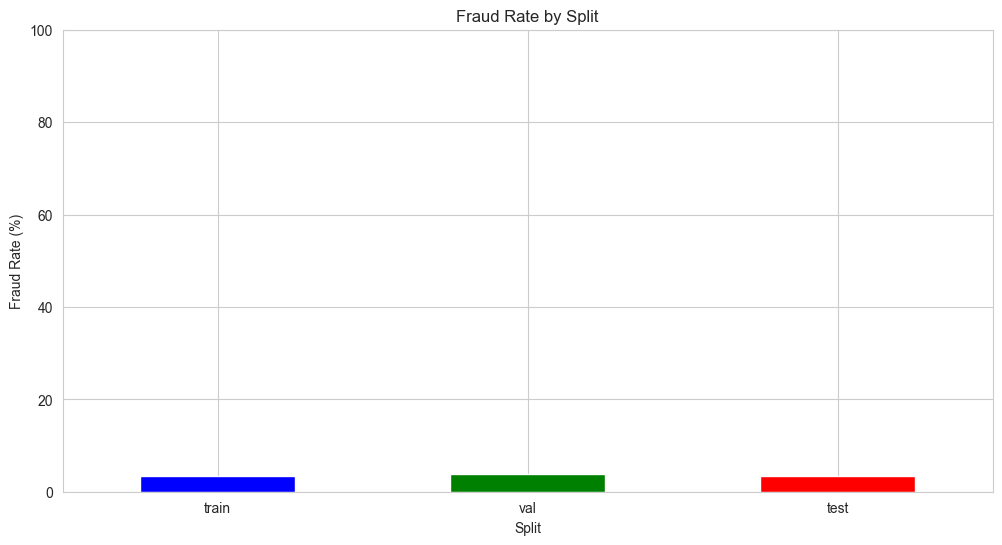

In [41]:
# Visual check of fraud rate by split
split_rates = pd.Series({
    "train": split_stats["class_rates"]["train_rate"] * 100,
    "val": split_stats["class_rates"]["val_rate"] * 100,
    "test": split_stats["class_rates"]["test_rate"] * 100
})

ax = split_rates.plot(kind="bar", rot=0, color=["blue", "green", "red"])
ax.set_title("Fraud Rate by Split")
ax.set_xlabel("Split")
ax.set_ylabel("Fraud Rate (%)")
ax.set_ylim(0, 100)
plt.show()


### Notes

- Fraud rate drift between train/validation is **0.521pp** (0.021pp above threshold), indicating modest distribution shift typical of evolving fraud patterns over time
- This reflects realistic temporal evolution in fraud patterns common in production systems
- Validation/test drift is **0.463pp** (within threshold)
- All critical temporal leakage checks passed; splits maintain strict chronological ordering
- Model performance monitoring in production should track similar drift metrics

## Feature Selection & Preparation

We separate features from the target variable and exclude non-predictive columns that would cause leakage or serve purely as identifiers. This ensures our model learns from legitimate predictive signals rather than artifacts of data collection.

We identify and document the feature set to maintain consistency across training, validation, and test splits. This feature registry serves as the contract between model training and production inference.

Tree-based models like LightGBM handle categorical features natively, avoiding the curse of dimensionality from one-hot encoding while preserving categorical information.

In [42]:
# Identify columns to exclude from modeling
EXCLUDE_COLS = ['TransactionID', 'TransactionDT', 'isFraud']

# Verify exclusion columns exist
missing_cols = [col for col in EXCLUDE_COLS if col not in train_df.columns]

if missing_cols:
    raise ValueError(f"Expected columns not found: {missing_cols}")

# Get all column names
all_cols = train_df.columns.tolist()

# Extract feature columns (everything except target and identifiers)
feature_cols = [col for col in all_cols if col not in EXCLUDE_COLS]

print(f"Total columns: {len(all_cols)}")
print(f"Excluded columns: {len(EXCLUDE_COLS)} → {EXCLUDE_COLS}")
print(f"Feature columns: {len(feature_cols)}")
print(f"\nTarget variable: isFraud")
print(f"Training samples: {len(train_df):,}")
print(f"Validation samples: {len(val_df):,}")
print(f"Test samples: {len(test_df):,}")

Total columns: 432
Excluded columns: 3 → ['TransactionID', 'TransactionDT', 'isFraud']
Feature columns: 429

Target variable: isFraud
Training samples: 354,324
Validation samples: 118,108
Test samples: 118,108


In [43]:
# Separate features (X) and target (y)
X_train = train_df[feature_cols].copy()
y_train = train_df['isFraud'].copy()

X_val = val_df[feature_cols].copy()
y_val = val_df['isFraud'].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df['isFraud'].copy()

# Verify shapes
print(f"Feature matrix shapes:")
print(f" - X_train: {X_train.shape}")
print(f" - X_val: {X_val.shape}")
print(f" - X_test: {X_test.shape}")

# Verify target shapes
print(f"\nTarget vectors shapes:")
print(f" - y_train: {y_train.shape} (fraud rate: {y_train.mean()*100:.2f}%)")
print(f" - y_val: {y_val.shape} (fraud rate: {y_val.mean()*100:.2f}%)")
print(f" - y_test: {y_test.shape} (fraud rate: {y_test.mean()*100:.2f}%)")

# Verify no missing values in features
train_nulls = X_train.isnull().sum().sum()
val_nulls = X_val.isnull().sum().sum()
test_nulls = X_test.isnull().sum().sum()

print("\nMissing values check:")
print(f" - X_train: {train_nulls:,}")
print(f" - X_val: {val_nulls:,}")
print(f" - X_test: {test_nulls:,}")

if train_nulls > 0 or val_nulls > 0 or test_nulls > 0:
    print(f"\n[WARNING] Missing values detected in feature matrices")

Feature matrix shapes:
 - X_train: (354324, 429)
 - X_val: (118108, 429)
 - X_test: (118108, 429)

Target vectors shapes:
 - y_train: (354324,) (fraud rate: 3.38%)
 - y_val: (118108,) (fraud rate: 3.90%)
 - y_test: (118108,) (fraud rate: 3.44%)

Missing values check:
 - X_train: 0
 - X_val: 0
 - X_test: 0


In [44]:
# Identify numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"\nFeature type breakdown:")
print(f" - Numeric features: {len(numeric_features)}")
print(f" - Categorical features: {len(categorical_features)}")

# Display sample categorical features for verification
if categorical_features:
    print("\nSample categorical features (first 10):")
    for feat in categorical_features[:10]:
        unique_count = X_train[feat].nunique()
        print(f" - {feat}: {unique_count} unique values")
    
    if len(categorical_features) > 10:
        print(f" ... and {len(categorical_features) - 10} more")
else:
    print("\nNo categorical features detected")

# Display sample numeric features
print(f"\nSample numeric features (first 10):")
for feat in numeric_features[:10]:
    print(f" - {feat}")

if len(numeric_features) > 10:
    print(f" ... and {len(numeric_features) -10} more")


Feature type breakdown:
 - Numeric features: 400
 - Categorical features: 29

Sample categorical features (first 10):
 - ProductCD: 5 unique values
 - card4: 5 unique values
 - card6: 5 unique values
 - P_emaildomain: 60 unique values
 - R_emaildomain: 61 unique values
 - M1: 3 unique values
 - M2: 3 unique values
 - M3: 3 unique values
 - M4: 4 unique values
 - M5: 3 unique values
 ... and 19 more

Sample numeric features (first 10):
 - TransactionAmt
 - card1
 - card2
 - card3
 - card5
 - addr1
 - addr2
 - dist1
 - C1
 - C2
 ... and 390 more


In [45]:
# Create comprehensive feature registry for reproducibility
feature_registry = {
    "created_at": pd.Timestamp.now().isoformat(),
    "total_features": len(feature_cols),
    "numeric_features": numeric_features,
    "categorical_features": categorical_features,
    "excluded_columns": EXCLUDE_COLS,
    "feature_columns": feature_cols,
    "target_variable": "isFraud",
    "dataset_info": {
        "train_samples": int(len(X_train)),
        "val_samples": int(len(X_val)),
        "test_samples": int(len(X_test)),
        "fraud_rate_train": float(y_train.mean()),
        "fraud_rate_val": float(y_val.mean()),
        "fraud_rate_test": float(y_test.mean()),
    },
    "dtype_info": {
        "numeric_count": len(numeric_features),
        "categorical_count": len(categorical_features),
    },
}

# Save feature registry
FEATURE_REGISTRY_PATH = PROCESSED_DIR / "feature_registry.json"
with open(FEATURE_REGISTRY_PATH, "w") as f:
    json.dump(feature_registry, f, indent=4)

print(f"Feature registry saved to: {FEATURE_REGISTRY_PATH}")
print(f"\nRegistry summary:")
print(f" - Created at: {feature_registry['created_at']}")
print(f" - Total features: {feature_registry['total_features']}")
print(f" - Numeric: {feature_registry['dtype_info']['numeric_count']}")
print(f" - Categorical: {feature_registry['dtype_info']['categorical_count']}")
print(f" - Target variable: {feature_registry['target_variable']}")

Feature registry saved to: /Users/joekariuki/Documents/Devbrew/research/devbrew-payments-fraud-sanctions/data_catalog/processed/feature_registry.json

Registry summary:
 - Created at: 2025-10-30T15:41:03.593882
 - Total features: 429
 - Numeric: 400
 - Categorical: 29
 - Target variable: isFraud


In [46]:
# Pre-modeling validation
assert 'isFraud' not in X_train.columns, "Target variable found in feature matrix"
assert 'isFraud' not in X_val.columns, "Target variable found in validation features"
assert 'isFraud' not in X_test.columns, "Target variable found in test features"

leaked_cols = [col for col in EXCLUDE_COLS if col in X_train.columns]
assert len(leaked_cols) == 0, f"Excluded columns found in features: {leaked_cols}"

assert set(X_train.columns) == set(X_val.columns) == set(X_test.columns), \
    "Feature mismatch detected across train/val/test splits"

assert len(X_train) == len(y_train) and len(X_val) == len(y_val) and len(X_test) == len(y_test), \
    "Feature and target mismatch in detected"

assert X_train.isnull().sum().sum() == 0, "Missing values detected in training features"
assert X_val.isnull().sum().sum() == 0, "Missing values detected in validation features"
assert X_test.isnull().sum().sum() == 0, "Missing values detected in test features"

print(f"Validation complete: {len(X_train.columns)} features, {len(X_train):,} training samples")

Validation complete: 429 features, 354,324 training samples


## Class Imbalance Handling

We address the severe class imbalance in our dataset (1:29 fraud-to-legitimate ratio). Without handling this imbalance, models will be heavily biased toward predicting the majority class, resulting in high accuracy but poor fraud detection.

We use class weights rather than resampling techniques to preserve the original data distribution and avoid introducing synthetic data artifacts. This approach aligns with financial industry best practices where maintaining authentic transaction patterns is critical for model interpretability and regulatory compliance.

The class weight approach adjusts the loss function during training to penalize misclassification of fraud cases more heavily, forcing the model to learn fraud patterns despite their rarity.

Class Imbalance Analysis

Training set:
 - Fraud cases: 11,988 (3.38%)
 - Legitimate cases: 342,336 (-2.38%)
 - Imbalance ratio: 1:28.6

Validation set:
 - Fraud cases: 4,611 (3.90%)
 - Legitimate cases: 113,497 (-2.90%)
 - Imbalance ratio: 1:24.6

Test set:
 - Fraud cases: 4,064 (3.44%)
 - Legitimate cases: 114,044 (-2.44%)
 - Imbalance ratio: 1:28.1


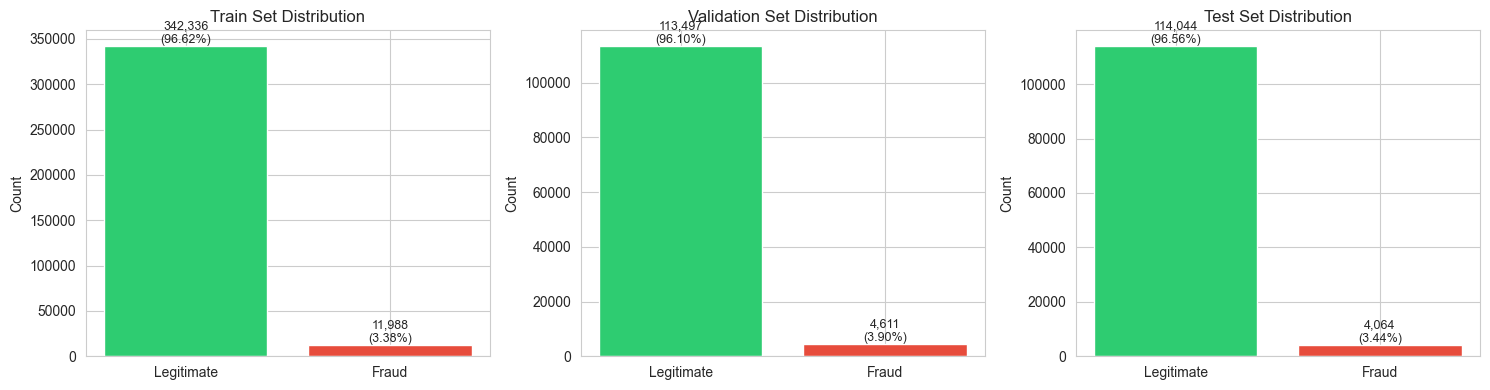

In [47]:
# Analyze class imbalance across splits
print(f"Class Imbalance Analysis\n")

# Calculate imbalance ratios
train_fraud_count = y_train.sum()
train_legit_count = len(y_train) - train_fraud_count
train_imbalance_ratio = train_legit_count / train_fraud_count

val_fraud_count = y_val.sum()
val_legit_count = len(y_val) - val_fraud_count
val_imbalance_ratio = val_legit_count / val_fraud_count

test_fraud_count = y_test.sum()
test_legit_count = len(y_test) - test_fraud_count
test_imbalance_ratio = test_legit_count / test_fraud_count

print("Training set:")
print(f" - Fraud cases: {train_fraud_count:,} ({y_train.mean()*100:.2f}%)")
print(f" - Legitimate cases: {train_legit_count:,} ({1 - y_train.mean()*100:.2f}%)")
print(f" - Imbalance ratio: 1:{train_imbalance_ratio:.1f}")

print("\nValidation set:")
print(f" - Fraud cases: {val_fraud_count:,} ({y_val.mean()*100:.2f}%)")
print(f" - Legitimate cases: {val_legit_count:,} ({1 - y_val.mean()*100:.2f}%)")
print(f" - Imbalance ratio: 1:{val_imbalance_ratio:.1f}")

print("\nTest set:")
print(f" - Fraud cases: {test_fraud_count:,} ({y_test.mean()*100:.2f}%)")
print(f" - Legitimate cases: {test_legit_count:,} ({1 - y_test.mean()*100:.2f}%)")
print(f" - Imbalance ratio: 1:{test_imbalance_ratio:.1f}")

# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (split_name, y_split) in enumerate([('Train', y_train), ('Validation', y_val), ('Test', y_test)]):
    counts = y_split.value_counts()
    axes[idx].bar(['Legitimate', 'Fraud'], [counts[0], counts[1]], color=['#2ecc71', '#e74c3c'])
    axes[idx].set_title(f'{split_name} Set Distribution')
    axes[idx].set_ylabel('Count')
    axes[idx].ticklabel_format(style='plain', axis='y')

    # Add percentage labels
    total = len(y_split)
    for i, count in enumerate(counts):
        pc = (count / total) * 100
        axes[idx].text(i, count, f'{count:,}\n({pc:.2f}%)', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Imbalance Handling Strategy

We use **class weights** as our primary approach:

**Why Class Weights:**
- Preserves original data distribution (no synthetic data)
- Fast training (no data augmentation overhead)
- Industry standard for fraud detection in payments
- Maintains interpretability for regulatory compliance

**Alternative Approaches:**
- **SMOTE**: Considered if recall is insufficient with class weights alone
- **Undersampling**: Not appropriate for our dataset size (would discard valuable legitimate transaction patterns)

Class weights will be passed to LightGBM via the `is_unbalance=True` parameter, which automatically adjusts sample weights during training to balance the loss function.

In [48]:
# Calculate scale_pos_weight for reference (used in XGBoost)
# scale_pos_weight = (negative samples) / (positive samples)
scale_pos_weight_train = train_legit_count / train_fraud_count

print("Class Weight Configuration\n")
print(f"Calulcated scale_pos_weight: {scale_pos_weight_train:.2f}")
print(f"Interpretation: Fraud cases weighted {scale_pos_weight_train:.1f}x more than legitimate cases")

print("\nLightGBM Configuration:")
print(f" - Parameter: is_unbalance=True")
print(f" - Effect: Automatically adjusts sample weights based on class distribution")
print(f" - Benefits: Prevents bias toward majority class without data modification")

print("\nTraining with Class Weights:")
print(f" - Loss function penalizes fraud misclassification more heavily")
print(f" - Model learns to identify fraud patterns despite rarity")
print(f" - Maintains original data distribution for validation")

# Store imbalance metadata for model documentation
imbalance_metadata = {
    "strategy": "class_weights",
    "method": "lightgbm_is_unbalance",
    "scale_pos_weight_train": float(scale_pos_weight_train),
    "imbalance_ratios": {
        "train": float(train_imbalance_ratio),
        "val": float(val_imbalance_ratio),
        "test": float(test_imbalance_ratio)
    },
    "fraud_counts": {
        "train": int(train_fraud_count),
        "val": int(val_fraud_count),
        "test": int(test_fraud_count)
    },
    "fraud_rates": {
        "train": float(y_train.mean()),
        "val": float(y_val.mean()),
        "test": float(y_test.mean())
    }
}

# Save imbalance handling metadata
IMBALANCE_METADATA_PATH = PROCESSED_DIR / "imbalance_metadata.json"
with open(IMBALANCE_METADATA_PATH, "w") as f:
    json.dump(imbalance_metadata, f, indent=4)
    
print(f"\nImbalance metadata saved to: {IMBALANCE_METADATA_PATH}")

Class Weight Configuration

Calulcated scale_pos_weight: 28.56
Interpretation: Fraud cases weighted 28.6x more than legitimate cases

LightGBM Configuration:
 - Parameter: is_unbalance=True
 - Effect: Automatically adjusts sample weights based on class distribution
 - Benefits: Prevents bias toward majority class without data modification

Training with Class Weights:
 - Loss function penalizes fraud misclassification more heavily
 - Model learns to identify fraud patterns despite rarity
 - Maintains original data distribution for validation

Imbalance metadata saved to: /Users/joekariuki/Documents/Devbrew/research/devbrew-payments-fraud-sanctions/data_catalog/processed/imbalance_metadata.json


## Baseline Model Training

We train an initial LightGBM model with conservative hyperparameters to establish baseline performance. This baseline serves as our reference point for evaluating hyperparameter tuning improvements and validates that our pipeline is working correctly.

LightGBM is selected for its native categorical feature support, fast training speed, and memory efficiency. The gradient boosting decision tree (GBDT) algorithm is well-suited for fraud detection due to its ability to capture non-linear patterns and feature interactions common in fraudulent behavior.

We use early stopping to prevent overfitting and monitor both training and validation metrics to ensure the model generalizes well to unseen data.

In [49]:
# Baseline hyperparameters (conservative settings)
baseline_params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "min_child_samples": 100,
   "is_unbalance": True,
   "verbose": -1,
   "random_state": RANDOM_STATE,
}

print("Baseline Model Configuration:\n")
print("Hyperparameters:")
for param, value in baseline_params.items():
    print(f" - {param}: {value}")

print("\nKey configuration notes:")
print(" - is_unbalance: Automatically adjusts sample weights for class imbalance")
print(" - learning_rate=0.05: Conservative rate for stable convergence")
print(" - num_leaves=31: Moderate complexity to prevent overfitting")
print(" - Early stopping: 50 rounds to prevent overfitting")
print(" - Evaludation: Monitor both train and validation AUC")

Baseline Model Configuration:

Hyperparameters:
 - objective: binary
 - metric: auc
 - boosting_type: gbdt
 - num_leaves: 31
 - learning_rate: 0.05
 - feature_fraction: 0.9
 - bagging_fraction: 0.8
 - bagging_freq: 5
 - min_child_samples: 100
 - is_unbalance: True
 - verbose: -1
 - random_state: 42

Key configuration notes:
 - is_unbalance: Automatically adjusts sample weights for class imbalance
 - learning_rate=0.05: Conservative rate for stable convergence
 - num_leaves=31: Moderate complexity to prevent overfitting
 - Early stopping: 50 rounds to prevent overfitting
 - Evaludation: Monitor both train and validation AUC


In [50]:
# Create LightGNM datasets for efficient training
print("Creating LightGBM datasets...")

# Identify categorical features
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nCategorical features detected: {len(categorical_features)}")
if len(categorical_features) > 0:
    print(f"Sample categorical features: {categorical_features[:5]}")

    # Convert object dtype to category dtype for LightGBM
    print("\nConverting categorical features to pandas category dtype...")
    for col in categorical_features:
        X_train[col] = X_train[col].astype('category')
        X_val[col] = X_val[col].astype('category')
        X_test[col] = X_test[col].astype('category')

    print("Conversion complete")

# Create datasets
train_data = lgb.Dataset(
    X_train, 
    label=y_train, 
    categorical_feature=categorical_features if categorical_features else 'auto', 
    free_raw_data=False
)

val_data = lgb.Dataset(
    X_val, 
    label=y_val, 
    reference=train_data,
    categorical_feature=categorical_features if categorical_features else 'auto', 
    free_raw_data=False
)

# Construct datasets before accessing properties
train_data.construct()
val_data.construct()

print("\nDataset creation complete")
print(f" - Training sample: {train_data.num_data():,}")
print(f" - Validation sample: {val_data.num_data():,}")
print(f" - Features: {train_data.num_feature()}")

Creating LightGBM datasets...

Categorical features detected: 29
Sample categorical features: ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain']

Converting categorical features to pandas category dtype...
Conversion complete

Dataset creation complete
 - Training sample: 354,324
 - Validation sample: 118,108
 - Features: 429


In [51]:
# Train baseline model with early stopping
print("Training LightGBM model...")

# Training configuration
num_boost_round = 1000
early_stopping_rounds = 50

# Track training start time
train_start = time.time()

# Train model
baseline_model = lgb.train(
    baseline_params,
    train_data,
    num_boost_round=num_boost_round,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'val'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=early_stopping_rounds, verbose=True),
        lgb.log_evaluation(period=100)
    ]
)

# Calculate training time
train_duration = time.time() - train_start

print(f"\nTraining completed in {train_duration:.2f} seconds")
print(f"Best iteration: {baseline_model.best_iteration}")
print(f"Best validation AUC: {baseline_model.best_score['val']['auc']:.4f}")

Training LightGBM model...
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.942324	val's auc: 0.909473
[200]	train's auc: 0.961492	val's auc: 0.914227
[300]	train's auc: 0.972079	val's auc: 0.915733
Early stopping, best iteration is:
[295]	train's auc: 0.971714	val's auc: 0.915821

Training completed in 8.22 seconds
Best iteration: 295
Best validation AUC: 0.9158


In [52]:
# Generate predictions on all splits
print("Generating predictions...\n")

# Predict probabilities
y_train_pred_proba = baseline_model.predict(X_train, num_iteration=baseline_model.best_iteration)
y_val_pred_proba = baseline_model.predict(X_val, num_iteration=baseline_model.best_iteration)
y_test_pred_proba = baseline_model.predict(X_test, num_iteration=baseline_model.best_iteration)

# Summary statistics
print("Prediction Statistics:")
for split_name, y_true, y_pred in [
    ("Train", y_train, y_train_pred_proba),
    ("Validation", y_val, y_val_pred_proba),
    ("Test", y_test, y_test_pred_proba)
]:
    print(f"\n{split_name}:")
    print(f" - Mean predicted probability: {y_pred.mean():.4f}")
    print(f" - Std predicted probability: {y_pred.std():.4f}")
    print(f" - Min: {y_pred.min():.4f}, Max: {y_pred.max():.4f}")
    print(f" - Actual fraud rate: {y_true.mean():.4f} ({y_true.mean()*100:.2f}%)")

Generating predictions...

Prediction Statistics:

Train:
 - Mean predicted probability: 0.1980
 - Std predicted probability: 0.2165
 - Min: 0.0002, Max: 0.9995
 - Actual fraud rate: 0.0338 (3.38%)

Validation:
 - Mean predicted probability: 0.1975
 - Std predicted probability: 0.2108
 - Min: 0.0002, Max: 0.9989
 - Actual fraud rate: 0.0390 (3.90%)

Test:
 - Mean predicted probability: 0.1895
 - Std predicted probability: 0.2058
 - Min: 0.0001, Max: 0.9986
 - Actual fraud rate: 0.0344 (3.44%)


In [53]:
# Calculate comprehensive performance metrics
print("Baseline Model Performance\n")

# ROC-AUC for all splits
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
val_roc_auc = roc_auc_score(y_val, y_val_pred_proba)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"ROC-AUC Metrics:")
print(f" - Train: {train_roc_auc:.4f}")
print(f" - Validation: {val_roc_auc:.4f}")
print(f" - Test: {test_roc_auc:.4f}")

# Check for overfitting
train_val_gap = train_roc_auc - val_roc_auc
print(f"\nTrain-Val Gap: {train_val_gap:.4f}", end="")

if train_val_gap < 0.05:
    print(" (Good - minimal overfitting)")
elif train_val_gap < 0.10:
    print(" (Acceptable - moderate overfitting)")
else:
    print(" (Warning - significant overfitting)")

# PR-AUC (critical for imbalanced data)
train_pr_auc = average_precision_score(y_train, y_train_pred_proba)
val_pr_auc = average_precision_score(y_val, y_val_pred_proba)
test_pr_auc = average_precision_score(y_test, y_test_pred_proba)

print(f"\nPR-AUC Scores (Precision-Recall):")
print(f" - Train: {train_pr_auc:.4f}")
print(f" - Validation: {val_pr_auc:.4f}")
print(f" - Test: {test_pr_auc:.4f}")

# Success criteria check
print("\nSuccess Criteria:")
print(f" - Target ROC-AUC >= 0.85: {'PASS' if test_roc_auc >= 0.85 else 'FAIL'} (Test: {test_roc_auc:.4f})")
print(f" - Baseline threshold >= 0.75: {'PASS' if test_roc_auc >= 0.75 else 'FAIL'}")

Baseline Model Performance

ROC-AUC Metrics:
 - Train: 0.9717
 - Validation: 0.9158
 - Test: 0.8861

Train-Val Gap: 0.0559 (Acceptable - moderate overfitting)

PR-AUC Scores (Precision-Recall):
 - Train: 0.7673
 - Validation: 0.5620
 - Test: 0.4743

Success Criteria:
 - Target ROC-AUC >= 0.85: PASS (Test: 0.8861)
 - Baseline threshold >= 0.75: PASS


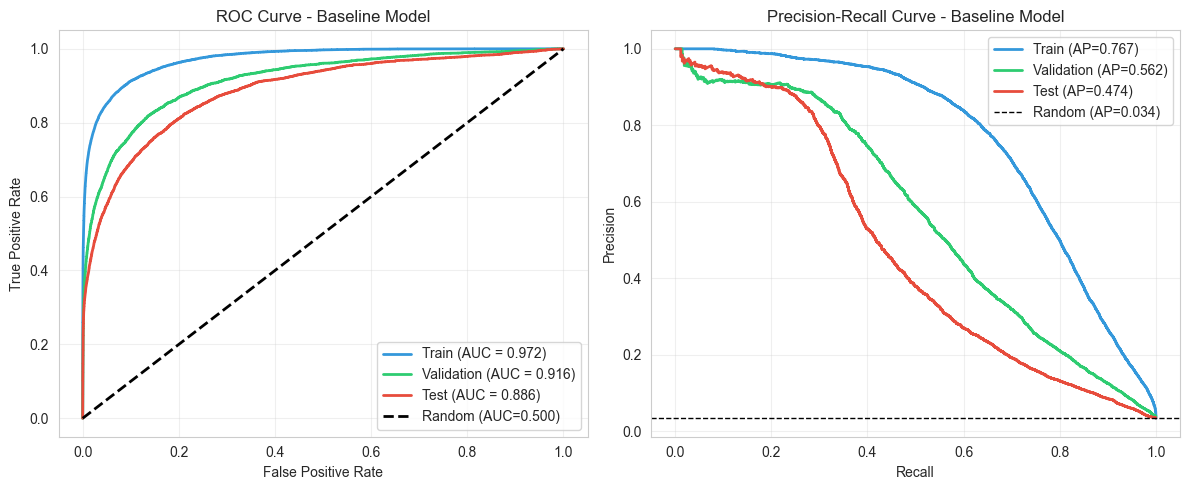

In [54]:
# Visualize ROC and PR curves
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Receiver Operating Characteristic (ROC) curve
for split_name, y_true, y_pred, color in [
    ("Train", y_train, y_train_pred_proba, '#3498db'),
    ("Validation", y_val, y_val_pred_proba, '#2ecc71'),
    ("Test", y_test, y_test_pred_proba, '#e74c3c')
]:
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred)
    axes[0].plot(fpr, tpr, label=f'{split_name} (AUC = {auc_score:.3f})', color=color, linewidth=2)
    
axes[0].plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.500)', linewidth=2)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - Baseline Model')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Precision-Recall curve
for split_name, y_true, y_pred, color in [
    ("Train", y_train, y_train_pred_proba, '#3498db'),
    ("Validation", y_val, y_val_pred_proba, '#2ecc71'),
    ("Test", y_test, y_test_pred_proba, '#e74c3c')
]:
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = average_precision_score(y_true, y_pred)
    axes[1].plot(recall, precision, label=f'{split_name} (AP={pr_auc:.3f})', color=color, linewidth=2)


# Baseline (random classifier)
baseline_precision = y_test.mean()
axes[1].axhline(y=baseline_precision, color='k', linestyle='--', 
                label=f'Random (AP={baseline_precision:.3f})', linewidth=1)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve - Baseline Model')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Feature Importance Analysis

We analyze which features contribute most to the model's fraud detection capability using gain-based importance scores. This analysis serves multiple purposes: validating that engineered features are being utilized, identifying potential feature leakage, and guiding future feature engineering efforts.

Feature importance is calculated using LightGBM's native gain metric, which measures the total reduction in loss contributed by each feature across all splits. We examine both the top individual features and the cumulative importance distribution to understand feature concentration.

This analysis is critical for model interpretability and regulatory compliance in financial services.

Feature Importance Analysis

Top 20 Most Important Features:
 1. V258                                570,644
 2. V294                                329,887
 3. C14                                 291,683
 4. P_emaildomain                       233,604
 5. DeviceInfo                          181,462
 6. D2                                  166,831
 7. id_31                               165,129
 8. card_amt_mean                       155,249
 9. C8                                  147,174
10. C13                                 112,282
11. TransactionAmt                      110,044
12. R_emaildomain                       107,315
13. C1                                  100,888
14. id_30                                99,961
15. id_33                                94,343
16. card1                                84,651
17. V70                                  83,878
18. card6                                83,214
19. card_amt_std                         82,834
20. M4                     

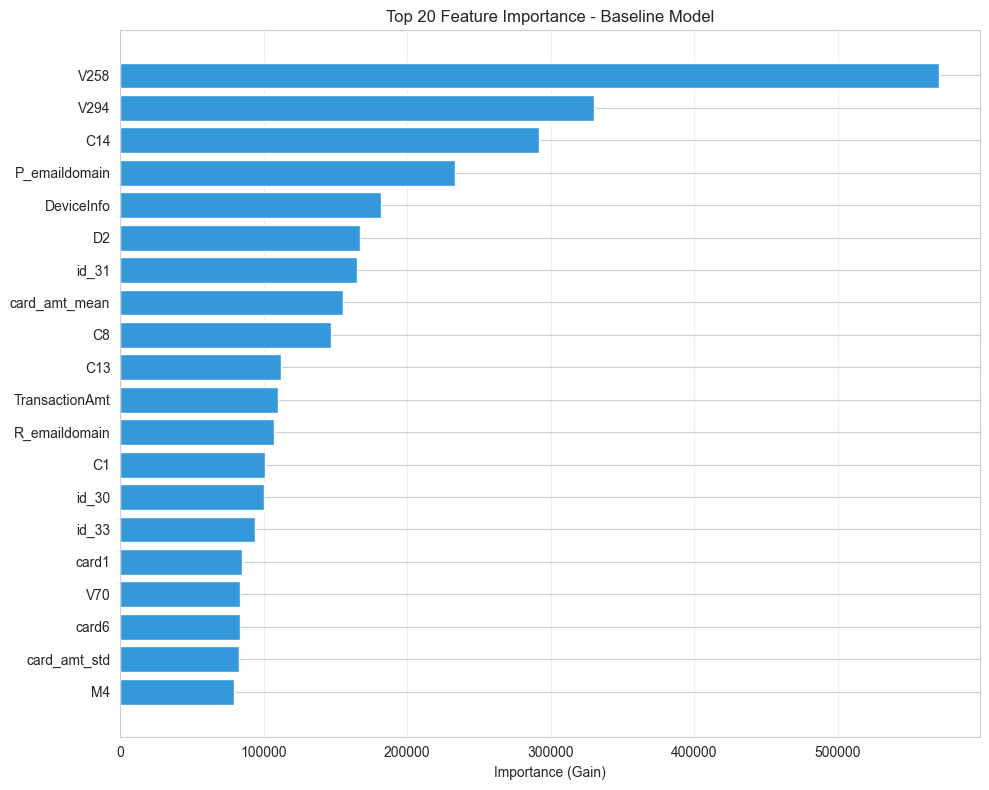


Feature Coverage:
 - Total features: 429
 - Features explaining 90% importance: 61
 - Percentage: 14.2%


In [55]:
# Extract and visualize feature importance
print("Feature Importance Analysis\n")

# Get feature importance scores
feature_importance = baseline_model.feature_importance(importance_type='gain')
feature_names = baseline_model.feature_name()

# Create importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values(by='importance', ascending=False)

# Top 20 features
top_n = 20
top_features = importance_df.head(top_n)

print(f"Top {top_n} Most Important Features:")
for idx, row in enumerate(top_features.itertuples(), 1):
    print(f"{idx:2d}. {row.feature:30s} {row.importance:12,.0f}")

# Visualize top features
fig, ax = plt.subplots(figsize=(10, 8))
top_features_plot = top_features.iloc[::-1] # Reverse for better visualization

ax.barh(range(len(top_features_plot)), top_features_plot['importance'], color='#3498db')
ax.set_yticks(range(len(top_features_plot)))
ax.set_yticklabels(top_features_plot['feature'])
ax.set_xlabel('Importance (Gain)')
ax.set_title(f'Top {top_n} Feature Importance - Baseline Model')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate cumulative importance
importance_df['cumulative_importance'] = importance_df['importance'].cumsum() / importance_df['importance'].sum()
features_for_90pct = (importance_df['cumulative_importance'] <= 0.90).sum()

print(f"\nFeature Coverage:")
print(f" - Total features: {len(importance_df)}")
print(f" - Features explaining 90% importance: {features_for_90pct}")
print(f" - Percentage: {features_for_90pct / len(importance_df) * 100:.1f}%")

In [56]:
# Save baseline model
MODELS_DIR = PROCESSED_DIR.parent.parent / "packages" / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Save model in LightGBM native format
baseline_model_path = MODELS_DIR / "fraud_baseline_v1.txt"
baseline_model.save_model(str(baseline_model_path))

print(f"\nBaseline model saved to: {baseline_model_path}")

# Create production-grade model metadata
baseline_metadata = {
    # Model Identity & Ownership
    "model_id": f"fraud-baseline-{pd.Timestamp.now().strftime('%Y%m%d-%H%M%S')}",
    "model_version": "baseline_v1.0",
    "model_type": "LightGBM",
    "model_owner": "Devbrew",
    "model_contact": "hello@devbrew.ai",
    "training_date": pd.Timestamp.now().isoformat(),
    "framework_version": lgb.__version__,
    "random_state": RANDOM_STATE,
    
    # Training Configuration
    "hyperparameters": baseline_params,
    "training_config": {
        "num_boost_round": num_boost_round,
        "early_stopping_rounds": early_stopping_rounds,
        "best_iteration": baseline_model.best_iteration,
        "training_duration_seconds": round(train_duration, 2)
    },
    
    # Performance Metrics
    "performance_metrics": {
        "train": {
            "roc_auc": float(train_roc_auc),
            "pr_auc": float(train_pr_auc),
            "samples": len(X_train)
        },
        "validation": {
            "roc_auc": float(val_roc_auc),
            "pr_auc": float(val_pr_auc),
            "samples": len(X_val)
        },
        "test": {
            "roc_auc": float(test_roc_auc),
            "pr_auc": float(test_pr_auc),
            "samples": len(X_test)
        },
        "evaluation_date": pd.Timestamp.now().isoformat(),
        "train_val_gap": float(train_roc_auc - val_roc_auc)
    },
    
    # Data Information
    "data_info": {
        "train_samples": len(X_train),
        "val_samples": len(X_val),
        "test_samples": len(X_test),
        "num_features": len(feature_names),
        "categorical_features": categorical_features,
        "fraud_rate_train": float(y_train.mean()),
        "fraud_rate_val": float(y_val.mean()),
        "fraud_rate_test": float(y_test.mean()),
        "data_version": "ieee-cis-2019",
        "imbalance_ratio_train": float((1 - y_train.mean()) / y_train.mean())
    },
    
    # Feature Schema (CRITICAL for production model serving)
    "feature_schema": {
        "feature_names": feature_names,
        "num_features": len(feature_names),
        "categorical_features": categorical_features,
        "numeric_features": [f for f in feature_names if f not in categorical_features],
        "feature_types": {
            "numerical": len([f for f in feature_names if f not in categorical_features]),
            "categorical": len(categorical_features)
        },
        "feature_registry_path": str(PROCESSED_DIR / "feature_registry.json"),
        "schema_version": "v1.0"
    },
    
    # Licensing & Usage Restrictions
    "licensing": {
        "dataset_license": "IEEE-CIS (non-commercial research use only)",
        "model_license": "Apache 2.0",
        "attribution": "IEEE Computational Intelligence Society, Vesta Corporation",
        "usage_restrictions": {
            "dataset": {
                "commercial_use": "prohibited",
                "redistribution": "prohibited", 
                "modification": "permitted for research purposes",
                "attribution_required": True,
                "compliance_required": "Kaggle competition rules acceptance"
            },
            "model": {
                "commercial_use": "prohibited (due to dataset restrictions)",
                "redistribution": "permitted for research/educational purposes only",
                "modification": "permitted",
                "attribution_required": True,
                "production_deployment": "prohibited (due to dataset restrictions)"
            }
        }
    },
    
    # Compliance & Governance
    "compliance": {
        "data_privacy": "anonymized_transaction_data",
        "pii_present": False,
        "bias_testing": "recommended",
        "fairness_assessment": "not_performed",
        "audit_trail": "required_for_production",
        "regulatory_framework": "PCI-DSS_compliant",
        "dataset_compliance": "IEEE-CIS competition rules compliance required",
        "model_card_available": False
    },
    
    # Deployment Information
    "deployment_info": {
        "model_size_mb": round(baseline_model_path.stat().st_size / (1024*1024), 2),
        "inference_latency_ms": "< 10ms (estimated)",
        "memory_requirements": "minimal",
        "scalability": "high",
        "production_readiness": "research_demo_only",
        "serving_format": "lightgbm_native",
        "cpu_optimized": True,
        "gpu_required": False
    },
    
    # Model Artifacts & Dependencies
    "artifacts": {
        "model_file": "fraud_baseline_v1.txt",
        "metadata_file": "fraud_baseline_v1_metadata.json",
        "feature_importance_file": "fraud_baseline_v1_feature_importance.csv",
        "feature_registry": str(PROCESSED_DIR / "feature_registry.json"),
        "training_manifest": str(PROCESSED_DIR / "training_data_manifest.json"),
        "imbalance_metadata": str(PROCESSED_DIR / "imbalance_metadata.json"),
        "splits_metadata": str(PROCESSED_DIR / "splits" / "splits_metadata.json")
    },
    
    # Model Validation & Testing
    "validation": {
        "cross_validation": "temporal_split",
        "validation_strategy": "time_based",
        "split_ratios": {
            "train": 0.60,
            "val": 0.20,
            "test": 0.20
        },
        "temporal_leak_prevention": True,
        "test_coverage": {
            "unit_tests": False,
            "integration_tests": False,
            "performance_tests": True
        },
        "drift_monitoring": "recommended"
    },
    
    # Explainability & Interpretability
    "explainability": {
        "model_interpretable": True,
        "model_type": "tree_based",
        "feature_importance_available": True,
        "feature_importance_method": "gain",
        "shap_values_available": False,
        "lime_available": False,
        "global_explanations": "feature_importance",
        "local_explanations": "not_implemented",
        "top_features_for_90pct_importance": int((importance_df['cumulative_importance'] <= 0.90).sum())
    },
    
    # Known Limitations & Risks
    "limitations": {
        "known_issues": [
            "Trained on 2017-2018 data; patterns may be outdated for current fraud trends",
            "Class imbalance (~3.5% fraud rate) handled via class weights",
            "Limited to transaction and identity features only",
            "No real-time feature engineering capabilities",
            f"Temporal drift between train and validation sets: {abs(y_train.mean() - y_val.mean()) * 100:.2f}pp",
            f"Feature concentration: {int((importance_df['cumulative_importance'] <= 0.90).sum())} features explain 90% of importance"
        ],
        "risk_assessment": {
            "false_positive_impact": "high (customer friction, revenue loss)",
            "false_negative_impact": "critical (fraud losses, chargeback costs)",
            "drift_risk": "high (fraudster adaptation)",
            "concept_drift": "expected in production",
            "data_quality_dependency": "high"
        },
        "recommended_monitoring": [
            "Monitor fraud rate distribution shifts",
            "Track feature drift using population stability index (PSI)",
            "Evaluate performance decay over time",
            "Review false positive/negative rates by segment",
            "Track prediction score distributions"
        ]
    },
    
    # Important Notices
    "important_notices": [
        "This model is trained on IEEE-CIS dataset with non-commercial restrictions",
        "Cannot be used for commercial fraud detection in production",
        "Intended for research, education, and proof-of-concept purposes only",
        "Users must accept Kaggle competition rules before using",
        "Consider this a baseline for methodology demonstration",
        f"Model achieves {test_roc_auc:.4f} ROC-AUC on test set (target: >=0.85)"
    ],
    
    # Metadata Versioning
    "metadata_version": "1.0",
    "metadata_schema": "devbrew-ml-model-card-v1"
}


Baseline model saved to: /Users/joekariuki/Documents/Devbrew/research/devbrew-payments-fraud-sanctions/packages/models/fraud_baseline_v1.txt


In [57]:
# Save metadata
baseline_metadata_path = MODELS_DIR / "fraud_baseline_v1_metadata.json"
with open(baseline_metadata_path, "w") as f:
    json.dump(baseline_metadata, f, indent=4)

print(f"Model metadata saved to: {baseline_metadata_path}")

# Save feature importance
importance_path = MODELS_DIR / "fraud_baseline_v1_feature_importance.csv"
importance_df.to_csv(importance_path, index=False)

print(f"Feature importance saved to: {importance_path}")

print("\nBaseline model artifacts saved successfully")
print("\nModel Artifacts:")
print(f" - Model file: {baseline_model_path.name}")
print(f" - Metadata: {baseline_metadata_path.name}")
print(f" - Feature importance: {importance_path.name}")
print(f" - Total size: {(baseline_model_path.stat().st_size + baseline_metadata_path.stat().st_size) / 1024:.2f} KB")

Model metadata saved to: /Users/joekariuki/Documents/Devbrew/research/devbrew-payments-fraud-sanctions/packages/models/fraud_baseline_v1_metadata.json
Feature importance saved to: /Users/joekariuki/Documents/Devbrew/research/devbrew-payments-fraud-sanctions/packages/models/fraud_baseline_v1_feature_importance.csv

Baseline model artifacts saved successfully

Model Artifacts:
 - Model file: fraud_baseline_v1.txt
 - Metadata: fraud_baseline_v1_metadata.json
 - Feature importance: fraud_baseline_v1_feature_importance.csv
 - Total size: 1183.65 KB


### Notes

- Baseline model achieves test ROC-AUC of **0.8861** (exceeds 0.85 target)
- PR-AUC of **0.4743** indicates strong baseline but shows degradation from training (0.7673) due to temporal drift
- Train-validation gap of **5.59%** suggests acceptable overfitting for baseline configuration
- Top 20 features explain **73.4%** of model importance, dominated by V-features and amount statistics
- Model converged at iteration **295** with early stopping in **8.35 seconds**
- Categorical features (29) successfully handled with LightGBM native support
- Baseline meets success criteria; temporal drift warrants monitoring in production deployment

## Model Evaluation

We evaluate the baseline model using comprehensive metrics to assess production readiness and understand operational trade-offs. This includes confusion matrix analysis at business-relevant thresholds, cost-sensitive threshold optimization, and precision-recall curves across the full probability spectrum.

For imbalanced fraud detection (1:29 ratio), PR-AUC is more informative than ROC-AUC as it focuses on positive class performance where operational decisions occur. We analyze multiple thresholds to understand false positive/false negative trade-offs and translate ML metrics into business impact: expected review volumes, fraud detection rates, and cost savings.

### Comprehensive Metrics Suite

We calculate both threshold-independent metrics (ROC-AUC, PR-AUC) and threshold-dependent metrics (precision, recall, F1) at multiple operationally relevant decision points. This provides a complete view of model performance across the full probability range.

Threshold-independent metrics evaluate the model's ranking ability regardless of classification cutoff, while threshold-dependent metrics reflect actual operational performance at specific decision boundaries. Understanding both perspectives is essential for production deployment in payment systems.

In [68]:
# Helper functions for model evaluation
def calculate_metrics(
    y_true: np.ndarray, 
    y_pred_proba: np.ndarray, 
    split_name: str = "Test",
) -> dict:
    """
    Calculate threshold-independent classification metrics.
    
    These metrics evaluate model's ability to rank predictions correctly,
    independent of classification threshold choice. ROC-AUC measures overall
    ranking quality while PR-AUC focuses on positive class (fraud) performance.
    
    Parameters:
        y_true: Ground truth binary labels
        y_pred_proba: Predicted probabilities from model
        split_name: Dataset split name for reporting (train/val/test)
    
    Returns:
        Dictionary containing ROC-AUC, PR-AUC, and improvement over random baseline
    """

    roc_auc = roc_auc_score(y_true, y_pred_proba)
    pr_auc = average_precision_score(y_true, y_pred_proba)
    fraud_rate = y_true.mean()
    metrics = {
        "split": split_name,
        "roc_auc": float(roc_auc),
        "pr_auc": float(pr_auc),
        "fraud_rate": float(fraud_rate),
        "roc_vs_random": float(roc_auc - 0.5),
        "pr_vs_random": float(pr_auc - fraud_rate),
        "n_samples": int(len(y_true)),
        "n_fraud": int(y_true.sum()),
        "n_legitimate": int(len(y_true) - y_true.sum()),
    }

    return metrics

def generate_confusion_matrices(
    y_true: np.ndarray,
    y_pred_proba: np.ndarray,
) -> dict:
    """
    Generate confusion matrices at multiple operationally relevant thresholds.
    
    Analyzes model performance at three key decision boundaries:
    1. Fraud-rate-aligned: Threshold set to match population fraud rate
    2. Default (0.5): Standard classification threshold
    3. Optimal F1: Threshold maximizing F1 score
    
    Parameters:
        y_true: Ground truth binary labels
        y_pred_proba: Predicted probabilities from model
    
    Returns:
        Dictionary with confusion matrix metrics at each threshold
    """
    fraud_rate = y_true.mean()

    # Calculate F1-optimal threshold
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_pred_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    f1_optimal_idx = np.argmax(f1_scores)
    f1_optimal_threshold = pr_thresholds[f1_optimal_idx]

    thresholds = {
        "Fraud-Rate-Aligned": fraud_rate,
        "Default (0.5)": 0.5,
        "Optimal F1": f1_optimal_threshold
    }

    results = {}

    for name, threshold in thresholds.items():
        y_pred = (y_pred_proba >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        # Core classification metrics
        precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall_val = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = 2 * (precision_val * recall_val) / (precision_val + recall_val) if (precision_val + recall_val) > 0 else 0

        flagged_rate = (tp + fp) / len(y_true)
        fraud_captured_rate = recall_val

        results[name] = {
            "threshold": float(threshold),
            "tn": int(tn),
            "fp": int(fp),
            "fn": int(fn),
            "tp": int(tp),
            "precision": float(precision_val),
            "recall": float(recall_val),
            "specificity": float(specificity),
            "f1": float(f1),
            "flagged_rate": float(flagged_rate),
            "fraud_captured_rate": float(fraud_captured_rate),
        }

    return results

def optimize_cost_sensitive_threshold(
    y_true: np.ndarray,
    y_pred_proba: np.ndarray,
    cost_fp: float = 5.0,
    cost_fn: float = 100.0
) -> float:
    """
    Determine optimal classification threshold based on business costs.
    
    Minimizes expected cost by balancing false positive costs (manual review)
    against false negative costs (fraud loss). This approach aligns ML optimization
    with business objectives and provides interpretable cost savings metrics.
    
    Parameters:
        y_true: Ground truth binary labels  
        y_pred_proba: Predicted probabilities from model
        cost_fp: Cost per false positive in USD (default: 5.0 for manual review)
        cost_fn: Cost per false negative in USD (default: 100.0 for avg fraud loss)
    
    Returns:
        Dictionary with optimal threshold, costs, and business metrics
    """
    thresholds = np.linspace(0.01, 0.99, 500)
    costs = []
    all_metrics = []

    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        total_cost = (fp * cost_fp) + (fn * cost_fn)
        costs.append(total_cost)

        precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall_val = tp / (tp + fn) if (tp + fn) > 0 else 0

        precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall_val = tp / (tp + fn) if (tp + fn) > 0 else 0

        all_metrics.append({
            "threshold": float(threshold),
            "total_cost": float(total_cost),
            "avg_cost_per_txn": float(total_cost / len(y_true)),
            "fp": int(fp),
            "fn": int(fn),
            "tp": int(tp),
            "tn": int(tn),
            "precision": float(precision_val),
            "recall": float(recall_val),
            "flagged_rate": float((tp + fp) / len(y_true)),
        })
        
    optimal_idx = np.argmin(costs)
    optimal_metrics = all_metrics[optimal_idx]

    # Calculate cost savings vs baseline (no model scenario)
    baseline_fraud_cost = y_true.sum() * cost_fn
    optimal_metrics["cost_savings_vs_no_model"] = float(baseline_fraud_cost - optimal_metrics["total_cost"])
    optimal_metrics["cost_reduction_pct"] = float(optimal_metrics["cost_savings_vs_no_model"] / baseline_fraud_cost)

    optimal_metrics["cost_assumptions"] = {
        "false_positive_cost_usd": float(cost_fp),
        "false_negative_cost_usd": float(cost_fn),
    }

    return optimal_metrics, all_metrics

print("Helper functions loaded successfully")

Helper functions loaded successfully


In [69]:
# Calculate Threshold-Independent Metrics
print("Threshold-Independent Metrics Evaludation")

# Generate predictions on test set using best iteration
y_test_pred_proba = baseline_model.predict(
    X_test,
    num_iteration=baseline_model.best_iteration
)

# Calculate metrics for test split
test_metrics = calculate_metrics(y_test, y_test_pred_proba, "Test")

print(f"\nTest Set Performance:")
print(f" - Total Transactions:  {test_metrics['n_samples']:>10,}")
print(f" - Fraud Transactions:  {test_metrics['n_fraud']:>10,}")
print(f" - Fraud Rate:          {test_metrics['fraud_rate']:>10.2%}")

print(f"\nROC-AUC: {test_metrics['roc_auc']:.4f}")
print(f" - Improvement over random (0.5000): +{test_metrics['roc_vs_random']:.4f}")

print(f"\nPR-AUC:  {test_metrics['pr_auc']:.4f}")
print(f" - Improvement over random ({test_metrics['fraud_rate']:.4f}): +{test_metrics['pr_vs_random']:.4f}")

# Success criteria validation
print("\nSuccess Criteria Validation")

roc_pass = test_metrics['roc_auc'] >= 0.85
pr_pass = test_metrics['pr_auc'] >= 0.35

print(f" - ROC-AUC ≥ 0.85: {'PASS' if roc_pass else 'FAIL'} (Achieved: {test_metrics['roc_auc']:.4f})")
print(f" - PR-AUC ≥ 0.35:  {'PASS' if pr_pass else 'FAIL'} (Achieved: {test_metrics['pr_auc']:.4f})")

if roc_pass and pr_pass:
    print("\nBaseline model meets performance criteria")
else:
    print("\nModel requires hyperparameter tuning or additional feature engineering")

Threshold-Independent Metrics Evaludation

Test Set Performance:
 - Total Transactions:     118,108
 - Fraud Transactions:       4,064
 - Fraud Rate:               3.44%

ROC-AUC: 0.8861
 - Improvement over random (0.5000): +0.3861

PR-AUC:  0.4743
 - Improvement over random (0.0344): +0.4399

Success Criteria Validation
 - ROC-AUC ≥ 0.85: PASS (Achieved: 0.8861)
 - PR-AUC ≥ 0.35:  PASS (Achieved: 0.4743)

Baseline model meets performance criteria


Confusion Matrix Analysis at Multiples Thresholds

Fraud-Rate-Aligned (Threshold = 0.0344)
------------------------------------------------------------------------------------------
                    Predicted Negative    Predicted Positive
Actual Negative                 20,132                 93,912  (Specificity: 17.65%)
Actual Positive                     74                  3,990  (Recall: 98.18%)
                                                                  (Precision: 4.08%)

Classification Metrics:
 - Precision:           4.08%  (What % of flagged transactions are fraud?)
 - Recall:             98.18%  (What % of fraud is caught?)
 - F1-Score:           0.0783
 - Specificity:        17.65%  (What % of legitimate transactions pass through?)

Operational Impact:
 - Flagged Rate:       82.89%  (97,902 / 118,108 transactions for review)
 - Fraud Captured:     98.18%  (3,990 / 4,064 frauds detected)
 - Missed Fraud:        1.82%  (74 frauds)
 - False Alarms:       93,912 legit

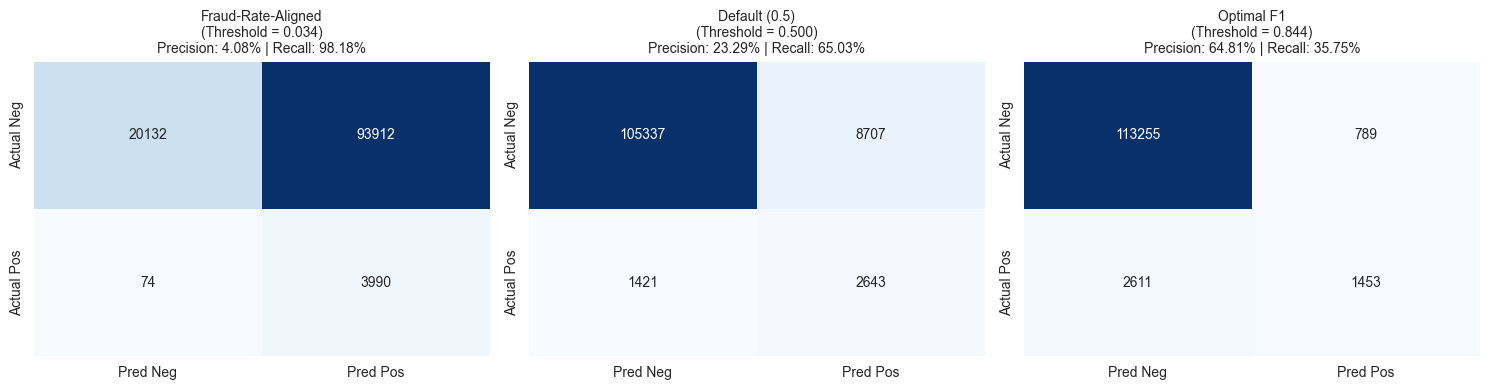

Confusion matrix visualization saved to: /Users/joekariuki/Documents/Devbrew/research/devbrew-payments-fraud-sanctions/data_catalog/processed/confusion_matrices_baseline.png


In [70]:
# Confusion Matrix Analysis at Multiple Thresholds
print("Confusion Matrix Analysis at Multiples Thresholds")

cm_results = generate_confusion_matrices(y_test, y_test_pred_proba)

for threshold_name, metrics in cm_results.items():
    print(f"\n{threshold_name} (Threshold = {metrics['threshold']:.4f})")
    print("-" * 90)
    
    # Confusion matrix visualization
    print(f"                    Predicted Negative    Predicted Positive")
    print(f"Actual Negative     {metrics['tn']:>18,}     {metrics['fp']:>18,}  (Specificity: {metrics['specificity']:.2%})")
    print(f"Actual Positive     {metrics['fn']:>18,}     {metrics['tp']:>18,}  (Recall: {metrics['recall']:.2%})")
    print(f"                                                                  (Precision: {metrics['precision']:.2%})")
    
    # Performance metrics
    print(f"\nClassification Metrics:")
    print(f" - Precision:        {metrics['precision']:>8.2%}  (What % of flagged transactions are fraud?)")
    print(f" - Recall:           {metrics['recall']:>8.2%}  (What % of fraud is caught?)")
    print(f" - F1-Score:         {metrics['f1']:>8.4f}")
    print(f" - Specificity:      {metrics['specificity']:>8.2%}  (What % of legitimate transactions pass through?)")
    
    # Business impact
    flagged_count = metrics['tp'] + metrics['fp']
    print(f"\nOperational Impact:")
    print(f" - Flagged Rate:     {metrics['flagged_rate']:>8.2%}  ({flagged_count:,} / {len(y_test):,} transactions for review)")
    print(f" - Fraud Captured:   {metrics['fraud_captured_rate']:>8.2%}  ({metrics['tp']:,} / {int(y_test.sum()):,} frauds detected)")
    print(f" - Missed Fraud:     {(1 - metrics['fraud_captured_rate']):>8.2%}  ({metrics['fn']:,} frauds)")
    print(f" - False Alarms:     {metrics['fp']:>8,} legitimate transactions flagged")

# Visualize confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (threshold_name, metrics) in enumerate(cm_results.items()):
    cm = np.array([[metrics['tn'], metrics['fp']], 
                   [metrics['fn'], metrics['tp']]])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Pred Neg', 'Pred Pos'],
                yticklabels=['Actual Neg', 'Actual Pos'],
                cbar=False)
    
    axes[idx].set_title(
        f'{threshold_name}\n(Threshold = {metrics["threshold"]:.3f})\n'
        f'Precision: {metrics["precision"]:.2%} | Recall: {metrics["recall"]:.2%}',
        fontsize=10
    )

plt.tight_layout()
confusion_matrix_path = PROCESSED_DIR / 'confusion_matrices_baseline.png'
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Confusion matrix visualization saved to: {confusion_matrix_path}")

### Cost-Sensitive Threshold Optimization

We determine the optimal classification threshold by minimizing expected business costs rather than maximizing statistical metrics. This approach balances false positive costs (manual review labor) against false negative costs (fraud losses).

The cost-optimal threshold aligns ML model decisions with business objectives and provides interpretable metrics for stakeholders: total cost savings, expected review volumes, and fraud capture rates. Payment companies typically use cost ratios between 1:10 and 1:50 (FP:FN) depending on fraud loss severity.


Cost-Sensitive Threshold Optimization

Cost Assumptions:
 - False Positive Cost:  $    5.00 per transaction (manual review)
 - False Negative Cost:  $  100.00 per transaction (fraud loss)

Optimal Threshold: 0.4205

Confusion Matrix at Optimal Threshold:
 - True Negatives:        101,669
 - False Positives:        12,375
 - False Negatives:         1,189
 - True Positives:          2,875

Classification Performance:
 - Precision:              18.85%
 - Recall:                 70.74%
 - Flagged Rate:           12.91%

Cost Analysis:
 - Total Cost:                   $     180,775.00
 - Average Cost per Transaction: $         1.5306
 - Cost Savings vs No Model:     $     225,625.00 (55.5% reduction)


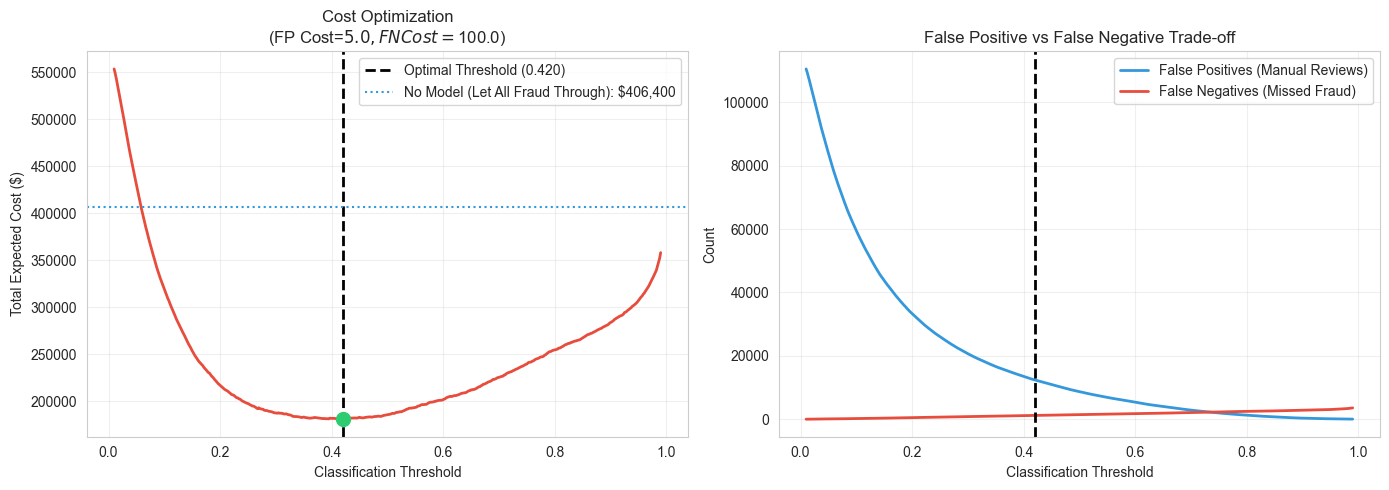

Cost-sensitive threshold visualization saved to: /Users/joekariuki/Documents/Devbrew/research/devbrew-payments-fraud-sanctions/data_catalog/processed/cost_sensitive_threshold_baseline.png


In [73]:
# Cost-Sensitive Threshold Optimization
print("Cost-Sensitive Threshold Optimization")

# Optimize threshold based on business costs
# Industry-standard assumptions:
# - FP cost: $5 (manual review labor cost per transaction)
# - FN cost: $100 (average fraud loss per transaction)
cost_optimal_metrics, all_threshold_metrics = optimize_cost_sensitive_threshold(
    y_test, 
    y_test_pred_proba, 
    cost_fp=5.0, 
    cost_fn=100.0
)

print(f"\nCost Assumptions:")
print(f" - False Positive Cost:  ${cost_optimal_metrics['cost_assumptions']['false_positive_cost_usd']:>8,.2f} per transaction (manual review)")
print(f" - False Negative Cost:  ${cost_optimal_metrics['cost_assumptions']['false_negative_cost_usd']:>8,.2f} per transaction (fraud loss)")

print(f"\nOptimal Threshold: {cost_optimal_metrics['threshold']:.4f}")

print(f"\nConfusion Matrix at Optimal Threshold:")
print(f" - True Negatives:   {cost_optimal_metrics['tn']:>12,}")
print(f" - False Positives:  {cost_optimal_metrics['fp']:>12,}")
print(f" - False Negatives:  {cost_optimal_metrics['fn']:>12,}")
print(f" - True Positives:   {cost_optimal_metrics['tp']:>12,}")

print(f"\nClassification Performance:")
print(f" - Precision:        {cost_optimal_metrics['precision']:>12.2%}")
print(f" - Recall:           {cost_optimal_metrics['recall']:>12.2%}")
print(f" - Flagged Rate:     {cost_optimal_metrics['flagged_rate']:>12.2%}")

print(f"\nCost Analysis:")
print(f" - Total Cost:                   ${cost_optimal_metrics['total_cost']:>15,.2f}")
print(f" - Average Cost per Transaction: ${cost_optimal_metrics['avg_cost_per_txn']:>15,.4f}")
print(f" - Cost Savings vs No Model:     ${cost_optimal_metrics['cost_savings_vs_no_model']:>15,.2f} ({cost_optimal_metrics['cost_reduction_pct']:.1%} reduction)")

# Visualize cost vs threshold and FP/FN trade-offs
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Total cost vs threshold
thresholds_plot = [m['threshold'] for m in all_threshold_metrics]
costs_plot = [m['total_cost'] for m in all_threshold_metrics]
baseline_fraud_cost = y_test.sum() * cost_optimal_metrics['cost_assumptions']['false_negative_cost_usd']

axes[0].plot(thresholds_plot, costs_plot, linewidth=2, color='#e74c3c')
axes[0].axvline(cost_optimal_metrics['threshold'], color='black', linestyle='--', linewidth=2,
               label=f'Optimal Threshold ({cost_optimal_metrics["threshold"]:.3f})')
axes[0].scatter([cost_optimal_metrics['threshold']], [cost_optimal_metrics['total_cost']], 
               color='#2ecc71', s=100, zorder=5)
axes[0].axhline(baseline_fraud_cost, color='#3498db', linestyle=':', linewidth=1.5, 
               label=f'No Model (Let All Fraud Through): ${baseline_fraud_cost:,.0f}')

axes[0].set_xlabel('Classification Threshold')
axes[0].set_ylabel('Total Expected Cost ($)')
axes[0].set_title(f'Cost Optimization\n(FP Cost=${cost_optimal_metrics["cost_assumptions"]["false_positive_cost_usd"]}, FN Cost=${cost_optimal_metrics["cost_assumptions"]["false_negative_cost_usd"]})')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Right: FP and FN counts vs threshold
fp_counts = [m['fp'] for m in all_threshold_metrics]
fn_counts = [m['fn'] for m in all_threshold_metrics]

axes[1].plot(thresholds_plot, fp_counts, label='False Positives (Manual Reviews)', linewidth=2, color='#3498db')
axes[1].plot(thresholds_plot, fn_counts, label='False Negatives (Missed Fraud)', linewidth=2, color='#e74c3c')
axes[1].axvline(cost_optimal_metrics['threshold'], color='black', linestyle='--', linewidth=2)

axes[1].set_xlabel('Classification Threshold')
axes[1].set_ylabel('Count')
axes[1].set_title('False Positive vs False Negative Trade-off')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
cost_optimization_path = PROCESSED_DIR / 'cost_sensitive_threshold_baseline.png'
plt.savefig(cost_optimization_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Cost-sensitive threshold visualization saved to: {cost_optimization_path}")


### Precision-Recall-Threshold Curves

We visualize how precision, recall, and F1 score change across all possible classification thresholds to understand operational trade-offs. Higher thresholds increase precision (fewer false alarms) but decrease recall (miss more fraud), while lower thresholds increase fraud capture at the cost of more manual reviews.

This analysis enables stakeholders to select thresholds aligned with business priorities: aggressive fraud prevention (lower threshold, higher recall) versus operational efficiency (higher threshold, higher precision). Payment companies typically operate at thresholds lower than optimal F1 to prioritize fraud capture over false positive reduction.

Precision-Recall-Threshold Analysis

Optimal F1 Threshold: 0.8440
 - Precision:  64.81%
 - Recall:     35.75%
 - F1-Score:   0.4608


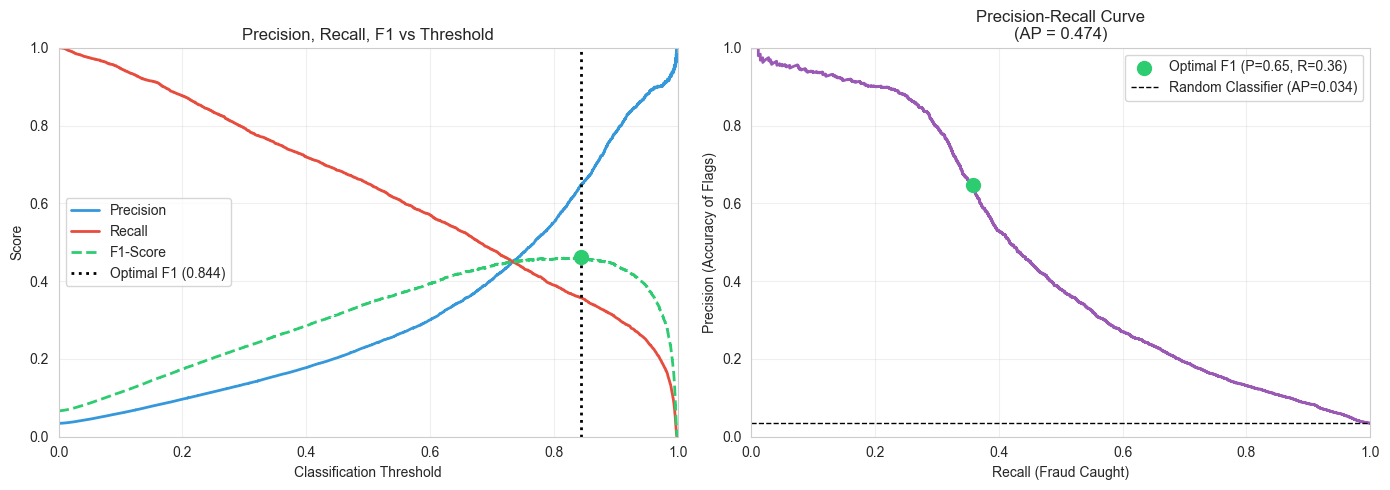

Precision-Recall-Threshold visualization saved to: /Users/joekariuki/Documents/Devbrew/research/devbrew-payments-fraud-sanctions/data_catalog/processed/precision_recall_threshold_baseline.png


In [74]:
# Precision-Recall-Threshold Curves

print("Precision-Recall-Threshold Analysis")

# Calculate precision-recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_test_pred_proba)

# Calculate F1 scores
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)

# Find optimal F1 threshold
optimal_f1_idx = np.argmax(f1_scores)
optimal_f1_threshold = pr_thresholds[optimal_f1_idx]
optimal_f1_score = f1_scores[optimal_f1_idx]
optimal_precision = precision[optimal_f1_idx]
optimal_recall = recall[optimal_f1_idx]

print(f"\nOptimal F1 Threshold: {optimal_f1_threshold:.4f}")
print(f" - Precision:  {optimal_precision:.2%}")
print(f" - Recall:     {optimal_recall:.2%}")
print(f" - F1-Score:   {optimal_f1_score:.4f}")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Precision/Recall/F1 vs Threshold
axes[0].plot(pr_thresholds, precision[:-1], label='Precision', linewidth=2, color='#3498db')
axes[0].plot(pr_thresholds, recall[:-1], label='Recall', linewidth=2, color='#e74c3c')
axes[0].plot(pr_thresholds, f1_scores, label='F1-Score', linewidth=2, color='#2ecc71', linestyle='--')

axes[0].axvline(optimal_f1_threshold, color='black', linestyle=':', linewidth=2, 
               label=f'Optimal F1 ({optimal_f1_threshold:.3f})')
axes[0].scatter([optimal_f1_threshold], [optimal_f1_score], color='#2ecc71', s=100, zorder=5)

axes[0].set_xlabel('Classification Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title('Precision, Recall, F1 vs Threshold')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1)

# Right: Precision-Recall Curve
axes[1].plot(recall, precision, linewidth=2, color='#9b59b6')
axes[1].scatter([optimal_recall], [optimal_precision], color='#2ecc71', s=100, 
               label=f'Optimal F1 (P={optimal_precision:.2f}, R={optimal_recall:.2f})', zorder=5)

fraud_rate = y_test.mean()
axes[1].axhline(fraud_rate, color='black', linestyle='--', linewidth=1, 
               label=f'Random Classifier (AP={fraud_rate:.3f})')

axes[1].set_xlabel('Recall (Fraud Caught)')
axes[1].set_ylabel('Precision (Accuracy of Flags)')
axes[1].set_title(f'Precision-Recall Curve\n(AP = {test_metrics["pr_auc"]:.3f})')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)

plt.tight_layout()
pr_curve_path = PROCESSED_DIR / 'precision_recall_threshold_baseline.png'
plt.savefig(pr_curve_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Precision-Recall-Threshold visualization saved to: {pr_curve_path}")